<a href="https://colab.research.google.com/github/Ryukijano/machinelearning/blob/master/DL-GANs-NORB/DCGAN/SelfCaseStudy_DCGAN_NORB_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DCGAN - TensorFlow implementation

### 1. Importing libraries

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf # '2.2.0'
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import seaborn as sns
import os
import PIL
import time
import imageio
import glob
from IPython import display
from datetime import datetime

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# device check
from tensorflow.python.client import device_lib
print('Devices:', device_lib.list_local_devices())

# GPU check
if not tf.test.gpu_device_name():
    print('No GPU found.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8601863288155300448
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8229246053602232465
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Default GPU Device: /device:GPU:0


In [3]:
def timer(start_time=None):
  if not start_time:
      start_time = datetime.now()
      return start_time
  elif start_time:
      thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
      tmin, tsec = divmod(temp_sec, 60)
      print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### 2. Loading the dataset

In [4]:
os.chdir('/content') # Google Colab - location to save or query files

In [5]:
# https://www.tensorflow.org/datasets/api_docs/python/tfds/load#args
# https://www.tensorflow.org/datasets/catalog/smallnorb
(ds_train, ds_test), ds_info = tfds.load(
    'smallnorb',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/24300 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/smallnorb/2.0.0.incompleteFT9J2C/smallnorb-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/24300 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/smallnorb/2.0.0.incompleteFT9J2C/smallnorb-test.tfrecord*...:   0%|          |…

Dataset smallnorb downloaded and prepared to ~/tensorflow_datasets/smallnorb/2.0.0. Subsequent calls will reuse this data.


In [6]:
# Print the loaded dataset information
print(ds_info)

tfds.core.DatasetInfo(
    name='smallnorb',
    full_name='smallnorb/2.0.0',
    description="""
    \
    This database is intended for experiments in 3D object recognition from shape. It contains images of 50 toys belonging to 5 generic categories: four-legged animals, human figures, airplanes, trucks, and cars. The objects were imaged by two cameras under 6 lighting conditions, 9 elevations (30 to 70 degrees every 5 degrees), and 18 azimuths (0 to 340 every 20 degrees).
    
    The training set is composed of 5 instances of each category (instances 4, 6, 7, 8 and 9), and the test set of the remaining 5 instances (instances 0, 1, 2, 3, and 5).
    """,
    homepage='https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/',
    data_path='~/tensorflow_datasets/smallnorb/2.0.0',
    file_format=tfrecord,
    download_size=250.60 MiB,
    dataset_size=230.92 MiB,
    features=FeaturesDict({
        'image': Image(shape=(96, 96, 1), dtype=tf.uint8),
        'image2': Image(shape=(96, 96, 1), 

In [7]:
DOWNSAMPLE_IMAGE_WIDTH = 96 
DOWNSAMPLE_IMAGE_HEIGHT = 96

### 3. Plots

In [8]:
def plot_dataset(ds_info, ds, rows=5, columns=5):
  fig=plt.figure(figsize=(21, 21))

  i = 1

  switcher = {}   
  # https://github.com/tensorflow/datasets/blob/master/README.md
  # https://www.tensorflow.org/datasets/overview
  for idx in range(ds_info.features['label_category'].num_classes):
    switcher[idx] = ds_info.features['label_category'].int2str(idx)

  # ax enables access to manipulate each of subplots
  ax = []
  for example in ds.take(columns*rows):  # Only take a single example
    image, label = example[0], example[1]
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i) )

    ax[-1].set_title("label_category: {0} - {1}".format(label.numpy(), switcher.get(label.numpy())))  # set title
    plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
    plt.axis('off')
    i += 1
  plt.show()

#### 3.1. Plotting train images

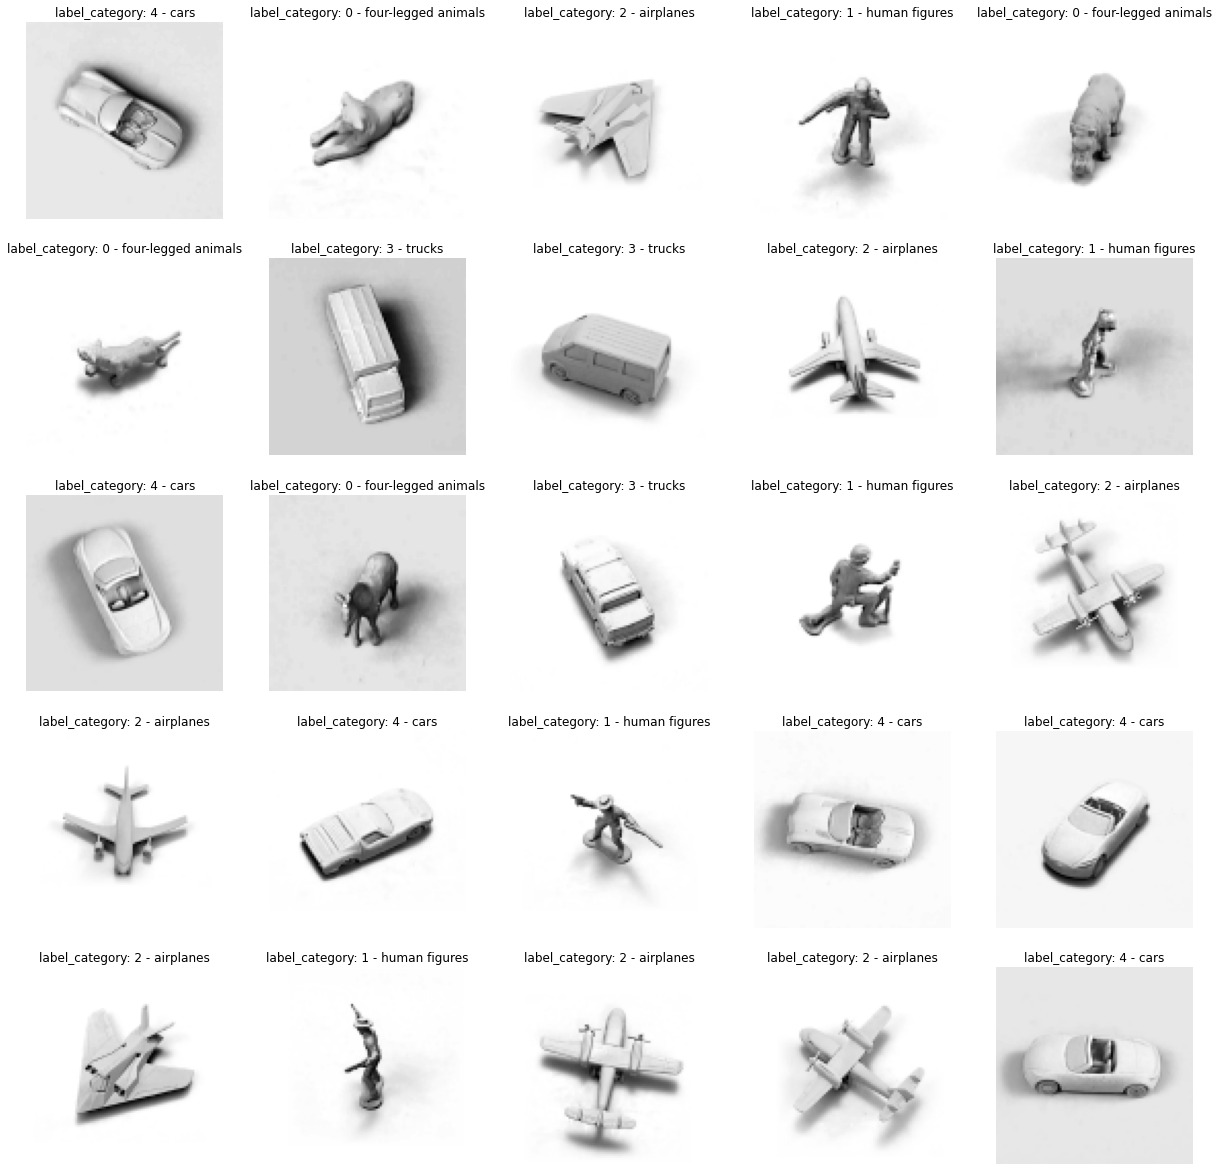

In [9]:
plot_dataset(ds_info, ds_train)

#### 3.2. Plotting test images

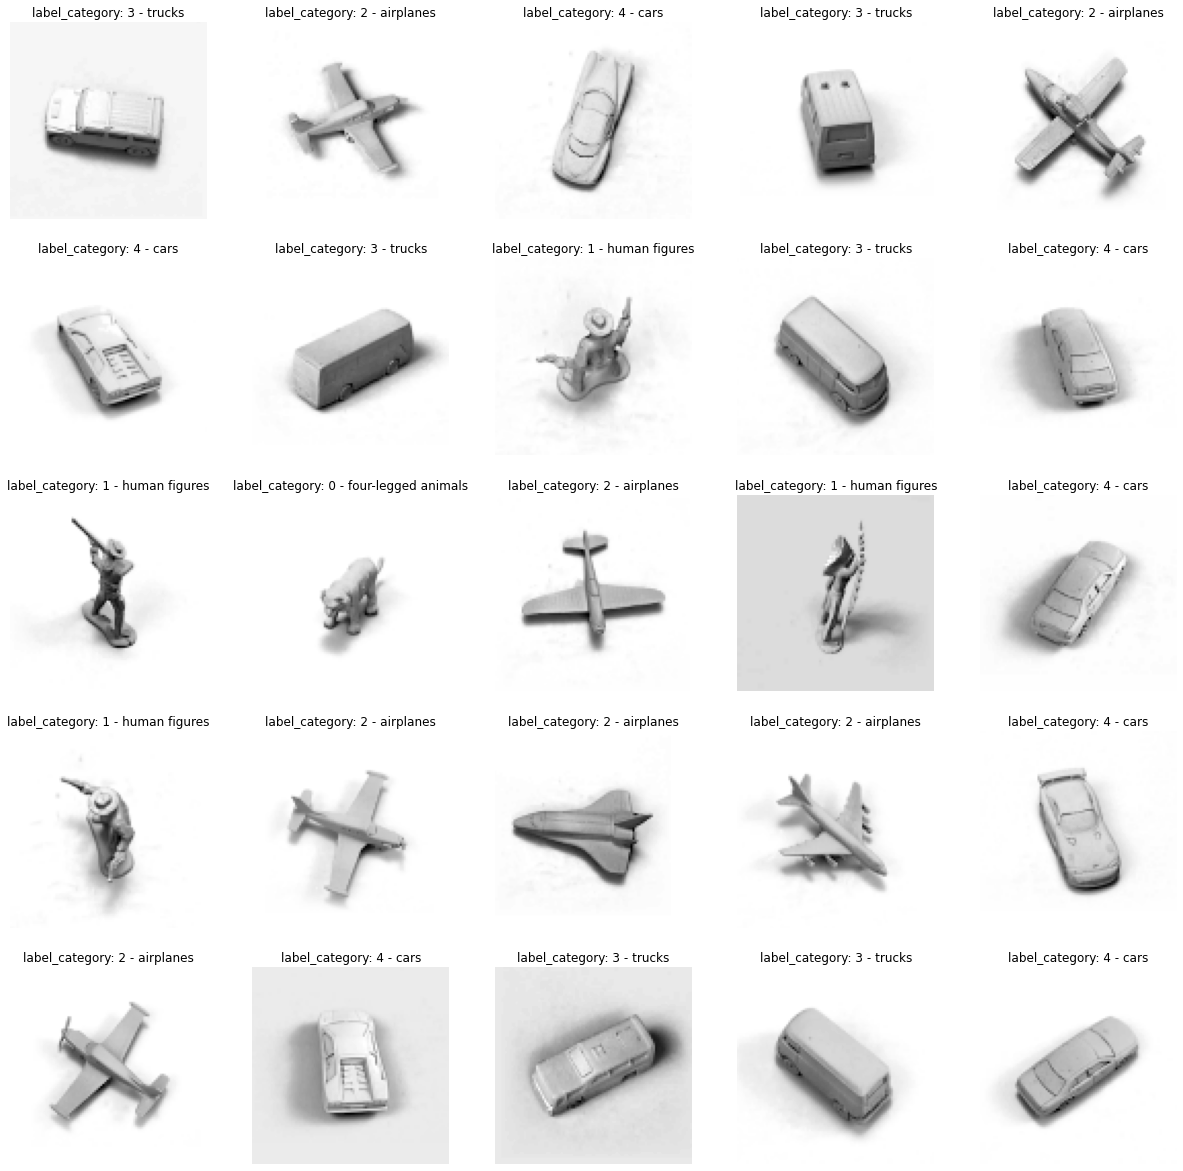

In [10]:
plot_dataset(ds_info, ds_test)

### 4. Normalizing, resizing and filtering the images

In [11]:
BUFFER_SIZE = 24300 # Individual class size: 4860 # Total dataset size : 24300
BATCH_SIZE = 8

In [12]:
def normalize_img(image, label_category):
  image = tf.cast(image, tf.float32) # TFDS provide the images as tf.uint8, while the model expect tf.float32, so normalize images
  image = tf.image.resize(image, (DOWNSAMPLE_IMAGE_WIDTH, DOWNSAMPLE_IMAGE_HEIGHT))
  image = (image - 127.5) / 127.5 # Normalize the images to [-1, 1]
  return image, label_category


ds_train_nrm = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Take only label_category 4 (cars) for image generation if required, also change BUFFER_SIZE accordingly
#ds_train_nrm = ds_train_nrm.filter(lambda x,y: tf.reduce_all(tf.not_equal(y, [0,1,2,3])))
# Select few images if needed
#ds_train_nrm = ds_train_nrm.take(100)
ds_train_nrm = ds_train_nrm.cache()
print("Length of dataset: ", ds_train_nrm.reduce(0, lambda x, _: x + 1).numpy())
ds_train_nrm = ds_train_nrm.shuffle(ds_train_nrm.reduce(0, lambda x, _: x + 1).numpy())  # shuffle(length_of_dataset)
ds_train_nrm = ds_train_nrm.batch(BATCH_SIZE)
ds_train_nrm = ds_train_nrm.prefetch(tf.data.experimental.AUTOTUNE)

Length of dataset:  24300


In [13]:
ds_test_nrm = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test_nrm = ds_test_nrm.filter(lambda x,y: tf.reduce_all(tf.not_equal(y, [0,1,2,3])))
ds_test_nrm = ds_test_nrm.batch(BATCH_SIZE)
ds_test_nrm = ds_test_nrm.cache()
ds_test_nrm = ds_test_nrm.prefetch(tf.data.experimental.AUTOTUNE)

### 5. Create the models

#### 5.1. The Generator

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    # project
    model.add(layers.Dense(24*24*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    # reshape
    model.add(layers.Reshape((24, 24, 256)))
    assert model.output_shape == (None, 24, 24, 256) # Note: None is the batch size
    # upsample or deconv1
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample or deconv2
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample or deconv3
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 96, 96, 1)
    return model

##### 5.1.1. Use the (as yet untrained) generator to create an image.

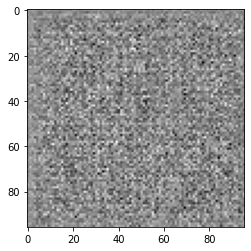

In [15]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#### 5.2. The Discriminator

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # conv 1
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[96, 96, 1]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    # conv 2
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

##### 5.2.1. Use the (as yet untrained) discriminator to classify the generated images as real or fake. 

In [17]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00022965]], shape=(1, 1), dtype=float32)


### 6. Define the loss and optimizers

#### 6.1. Define loss functions and optimizers for both models.

In [18]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### 6.2. Discriminator loss

In [19]:
def discriminator_loss(real_output, fake_output):
    # compares the discriminator's predictions on real images to an array of 1s (class 1 - real)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # compares the discriminator's predictions on fake (generated) images to an array of 0s (class 0 - fake)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### 6.3. Generator loss

In [20]:
def generator_loss(fake_output):
    # if the generator is performing well, the discriminator will classify the fake images as real (or 1)
    # therefore, compare the discriminators decisions on the generated images to an array of 1s
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### 6.4. Train two networks separately since optimizers are different

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

#### 6.5. Save checkpoints

In [22]:
checkpoint_dir = 'training_checkpoints'
os.mkdir(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 7. Define the training loop

In [23]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 25

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # Generate noise(or seed) drawn from standard normal distribution 
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Pass this noise(or seed) as an input to generator
      # This noise(or seed) is used to produce an image
      generated_images = generator(noise, training=True)
      # Classify real images using discriminator
      # Note that the output is not a probability value
      real_output = discriminator(images, training=True)
      # Classify fake images using discriminator
      fake_output = discriminator(generated_images, training=True)
      # Calculate the loss
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      
    # Calculate the gradients (or partial derivatives)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply the gradients (backpropagation)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [25]:
def train(dataset, epochs):
  gen_loss_list = []
  disc_loss_list = []
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch[0])
      
    gen_loss_list.append(gen_loss.numpy())
    disc_loss_list.append(disc_loss.numpy())
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  return gen_loss_list, disc_loss_list

#### 7.1. Generate and save images

In [26]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(21,21)) 

  for i in range(predictions.shape[0]):
      
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### 8. Train the model

In [27]:
# Instructions for training the model for particular class, let us pick class 3
# First filter the images for class 3 
# ds_train_nrm = ds_train_nrm.filter(lambda x,y: tf.reduce_all(tf.not_equal(y, [0,1,2,4])))
# set BUFFER_SIZE = 4860 which is equal to number of samples in this class
# and set BATCH_SIZE = 64

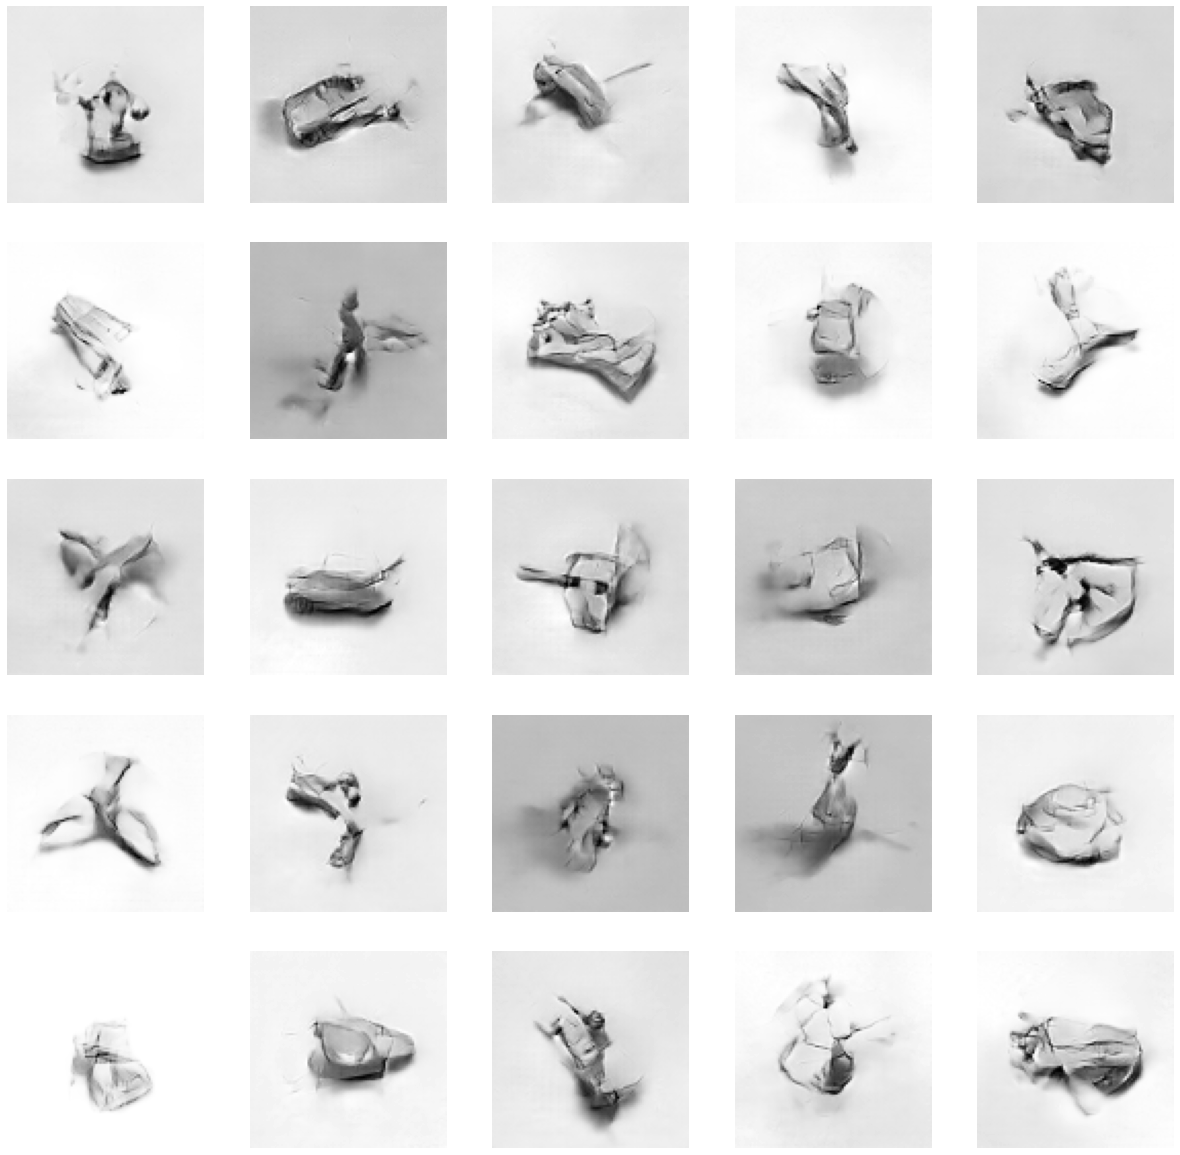

Time taken: 1 hours 31 minutes and 13.38 seconds.


In [28]:
# class 3 - trucks
start_time = timer(None) # timing starts from this point for "start_time" variable
gen_loss_list, disc_loss_list = train(ds_train_nrm, EPOCHS)
timer(start_time) # timing ends here for "start_time" variable

### 9. Plotting the loss

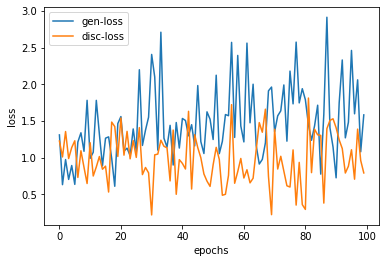

In [29]:
# class 3 - trucks
plt.plot(np.array(gen_loss_list), label='gen-loss')
plt.plot(np.array(disc_loss_list), label='disc-loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### 10. Create a GIF

In [30]:
# To generate GIFs
!pip install -qq imageio

In [31]:
anim_file = 'norb_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

### 11. Downloading files

In [32]:
# Code to download GIF
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
# Code to download all the pngs generated by DCGAN
try:
  from google.colab import files
except ImportError:
   pass
else:
  for epoch_no in range(1, EPOCHS+1):
    files.download('image_at_epoch_{:04d}.png'.format(epoch_no))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
# Code to zip the training checkpoints
!zip -rqq training_checkpoints.zip training_checkpoints

In [35]:
# Code to download training checkpoints zip
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('training_checkpoints.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## DCGAN - TensorFlow.Keras implementation

### 1. Importing libraries

In [36]:
import numpy as np
from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint

import tensorflow as tf # '2.2.0'
import tensorflow_datasets as tfds
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.layers import Activation, BatchNormalization
 
%matplotlib inline
from matplotlib import pyplot

### 2. Define the discriminator

In [37]:
# define the standalone unsupervised discriminator model
def define_discriminator(in_shape=(96,96,1), n_classes=1):
  # image input
  in_image = Input(shape=in_shape)
    
  # downsample
  fe = Conv2D(64, (5,5), strides=(2,2), padding='same') (in_image)
  fe = LeakyReLU(alpha=0.2)                             (fe)
  # dropout
  fe = Dropout(0.4)                                     (fe)
  # downsample
  fe = Conv2D(128, (5,5), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)                             (fe)
  # dropout
  fe = Dropout(0.4)                                     (fe)

  # flatten feature maps
  fe = Flatten()                                        (fe)
  # output layer
  d_out_layer = Dense(1, activation='sigmoid')          (fe)

  # define and compile unsupervised discriminator model
  d_model = Model(in_image, d_out_layer)
  d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
  return d_model

### 3. Define the generator

In [38]:
# define the standalone generator model
def define_generator(latent_dim):
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 24x24 image
  n_nodes = 24 * 24 * 256
  gen = Dense(n_nodes, use_bias=False)                            (in_lat)
  gen = BatchNormalization()                                      (gen)
  gen = LeakyReLU(alpha=0.2)                                      (gen)
  gen = Reshape((24, 24, 256))                                    (gen)

  # upsample to 24x24
  gen = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', 
                        use_bias=False)                           (gen)
  gen = BatchNormalization()                                      (gen)
  gen = LeakyReLU(alpha=0.2)                                      (gen)

  # upsample to 48x48
  gen = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', 
                        use_bias=False)                           (gen)
  gen = LeakyReLU(alpha=0.2)                                      (gen)
  gen = BatchNormalization()                                      (gen)

  # upsample to 96x96
  # output
  out_layer = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', 
                              use_bias=False, activation='tanh')  (gen)
  
  # define model
  model = Model(in_lat, out_layer)
  return model

### 4. Define GAN

In [39]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect image output from generator as input to discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and outputting a classification
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

### 5. Load the dataset

In [40]:
# load the images
def load_real_samples():
  # load dataset
  X_train, y_train = tfds.as_numpy(tfds.load(
                        'smallnorb',
                        split='train', 
                        batch_size=-1, 
                        as_supervised=True,
                    ))

  # convert from ints to floats
  X = X_train.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  print(X.shape, y_train.shape)
  return [X, y_train]

### 6. Select images (or samples) based on the class

In [41]:
# select a supervised subset of the dataset
def select_supervised_samples(dataset, n_samples=100, n_classes=5):
	X, y = dataset
	X_list, y_list = list(), list()
	class_list = [4] # for filtering, for entire dataset = [0,1,2,3,4]
	n_classes = len(class_list)
	n_per_class = int(n_samples / n_classes)
	for i in class_list:
		# get all images for this class
		X_with_class = X[y == i]
		# choose rando3m instances
		ix = randint(0, len(X_with_class), n_per_class)
		# add to list
		[X_list.append(X_with_class[j]) for j in ix]
		[y_list.append(i) for j in ix]
	return asarray(X_list), asarray(y_list)

### 7. Select some real images (or samples)

In [42]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

### 8. Generate some random noise 

In [43]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input

### 9. Generate some fake images (or samples) from random noise 

In [44]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1))
	return images, y

### 10. Visualization utility function

In [45]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, dataset, n_samples=25):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)

	fig = pyplot.figure(figsize=(21,21)) 
	# plot images
	for i in range(n_samples):
		# define subplot
		pyplot.subplot(5, 5, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# evaluate the classifier model
	X, y = dataset
	
	# save the generator model
	filename2 = 'g_model_%04d.h5' % (step+1)
	g_model.save(filename2)

	print('>Saved: %s, and %s' % (filename1, filename2))

### 11. Define the training loop

In [46]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=64):
	# select supervised dataset
	X_sup, y_sup = select_supervised_samples(dataset)
	print(X_sup.shape, y_sup.shape)
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, half_batch=%d, batch_per_epoch=%d, n_steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	# manually enumerate epochs
	for i in range(n_steps):
		# update unsupervised discriminator (d)
		[X_real, _], y_real = generate_real_samples(dataset, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update generator (g)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		# summarize loss on this batch
		print('>%d, d[%.3f,%.3f], g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, latent_dim, dataset)

### 12. Train the model

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator models
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

(24300, 96, 96, 1) (24300,)
(100, 96, 96, 1) (100,)
n_epochs=200, n_batch=64, half_batch=32, batch_per_epoch=379, n_steps=75800
1/1 [==============================] - 0s 208ms/step
>1, d[0.691,0.696], g[0.562]
1/1 [==============================] - 0s 13ms/step
>2, d[0.510,0.697], g[0.442]
1/1 [==============================] - 0s 13ms/step
>3, d[0.308,0.699], g[0.336]
1/1 [==============================] - 0s 14ms/step
>4, d[0.179,0.697], g[0.279]
1/1 [==============================] - 0s 14ms/step
>5, d[0.067,0.688], g[0.274]
1/1 [==============================] - 0s 13ms/step
>6, d[0.140,0.673], g[0.285]
1/1 [==============================] - 0s 16ms/step
>7, d[0.144,0.651], g[0.337]
1/1 [==============================] - 0s 13ms/step
>8, d[0.158,0.615], g[0.537]
1/1 [==============================] - 0s 13ms/step
>9, d[0.076,0.543], g[1.080]
1/1 [==============================] - 0s 15ms/step
>10, d[0.055,0.415], g[1.912]
1/1 [==============================] - 0s 15ms/step
>11, d[0

>Saved: generated_plot_0379.png, and g_model_0379.h5
1/1 [==============================] - 0s 17ms/step
>380, d[0.001,0.194], g[0.000]
1/1 [==============================] - 0s 17ms/step
>381, d[0.005,0.000], g[0.000]
1/1 [==============================] - 0s 14ms/step
>382, d[0.025,0.007], g[0.000]
1/1 [==============================] - 0s 13ms/step
>383, d[0.001,0.000], g[0.000]
1/1 [==============================] - 0s 14ms/step
>384, d[0.001,0.001], g[0.001]
1/1 [==============================] - 0s 13ms/step
>385, d[0.001,0.001], g[0.000]
1/1 [==============================] - 0s 13ms/step
>386, d[0.001,0.007], g[0.000]
1/1 [==============================] - 0s 12ms/step
>387, d[0.002,0.001], g[0.000]
1/1 [==============================] - 0s 12ms/step
>388, d[0.002,0.001], g[0.000]
1/1 [==============================] - 0s 13ms/step
>389, d[0.003,0.001], g[0.000]
1/1 [==============================] - 0s 14ms/step
>390, d[0.001,0.001], g[0.000]
1/1 [=============================

>Saved: generated_plot_0758.png, and g_model_0758.h5
1/1 [==============================] - 0s 19ms/step
>759, d[0.015,0.009], g[0.028]
1/1 [==============================] - 0s 16ms/step
>760, d[0.009,0.008], g[0.025]
1/1 [==============================] - 0s 13ms/step
>761, d[0.016,0.014], g[0.026]
1/1 [==============================] - 0s 13ms/step
>762, d[0.009,0.013], g[0.027]
1/1 [==============================] - 0s 13ms/step
>763, d[0.005,0.014], g[0.031]
1/1 [==============================] - 0s 17ms/step
>764, d[0.013,0.009], g[0.034]
1/1 [==============================] - 0s 16ms/step
>765, d[0.013,0.016], g[0.027]
1/1 [==============================] - 0s 16ms/step
>766, d[0.022,0.019], g[0.031]
1/1 [==============================] - 0s 13ms/step
>767, d[0.015,0.017], g[0.032]
1/1 [==============================] - 0s 18ms/step
>768, d[0.008,0.014], g[0.038]
1/1 [==============================] - 0s 13ms/step
>769, d[0.009,0.009], g[0.040]
1/1 [=============================

>Saved: generated_plot_1137.png, and g_model_1137.h5
1/1 [==============================] - 0s 14ms/step
>1138, d[0.396,0.311], g[1.908]
1/1 [==============================] - 0s 15ms/step
>1139, d[0.513,0.103], g[2.095]
1/1 [==============================] - 0s 13ms/step
>1140, d[0.335,0.492], g[1.637]
1/1 [==============================] - 0s 14ms/step
>1141, d[0.573,0.388], g[1.624]
1/1 [==============================] - 0s 13ms/step
>1142, d[0.572,0.505], g[1.430]
1/1 [==============================] - 0s 13ms/step
>1143, d[0.384,0.212], g[1.529]
1/1 [==============================] - 0s 14ms/step
>1144, d[0.426,0.340], g[2.014]
1/1 [==============================] - 0s 13ms/step
>1145, d[0.603,0.074], g[2.116]
1/1 [==============================] - 0s 13ms/step
>1146, d[0.336,0.572], g[1.485]
1/1 [==============================] - 0s 17ms/step
>1147, d[0.524,0.404], g[1.416]
1/1 [==============================] - 0s 13ms/step
>1148, d[0.376,0.476], g[1.487]
1/1 [==================

>Saved: generated_plot_1516.png, and g_model_1516.h5
1/1 [==============================] - 0s 14ms/step
>1517, d[0.534,0.465], g[1.820]
1/1 [==============================] - 0s 13ms/step
>1518, d[0.531,0.437], g[1.888]
1/1 [==============================] - 0s 15ms/step
>1519, d[0.518,0.075], g[3.315]
1/1 [==============================] - 0s 13ms/step
>1520, d[0.346,0.392], g[2.056]
1/1 [==============================] - 0s 13ms/step
>1521, d[0.204,0.453], g[1.709]
1/1 [==============================] - 0s 20ms/step
>1522, d[0.460,0.409], g[1.815]
1/1 [==============================] - 0s 27ms/step
>1523, d[0.417,0.139], g[2.085]
1/1 [==============================] - 0s 15ms/step
>1524, d[0.299,0.600], g[1.453]
1/1 [==============================] - 0s 16ms/step
>1525, d[0.268,0.545], g[2.137]
1/1 [==============================] - 0s 12ms/step
>1526, d[0.692,0.542], g[2.103]
1/1 [==============================] - 0s 12ms/step
>1527, d[0.513,0.162], g[1.932]
1/1 [==================

>Saved: generated_plot_1895.png, and g_model_1895.h5
1/1 [==============================] - 0s 17ms/step
>1896, d[0.384,0.356], g[1.603]
1/1 [==============================] - 0s 14ms/step
>1897, d[0.429,0.660], g[1.506]
1/1 [==============================] - 0s 13ms/step
>1898, d[0.438,0.345], g[1.768]
1/1 [==============================] - 0s 12ms/step
>1899, d[0.372,0.352], g[1.760]
1/1 [==============================] - 0s 15ms/step
>1900, d[0.357,0.300], g[2.026]
1/1 [==============================] - 0s 12ms/step
>1901, d[0.411,0.212], g[1.786]
1/1 [==============================] - 0s 15ms/step
>1902, d[0.368,0.490], g[1.513]
1/1 [==============================] - 0s 21ms/step
>1903, d[0.275,0.632], g[1.999]
1/1 [==============================] - 0s 16ms/step
>1904, d[0.686,0.364], g[2.099]
1/1 [==============================] - 0s 16ms/step
>1905, d[0.559,0.463], g[2.494]
1/1 [==============================] - 0s 13ms/step
>1906, d[0.578,0.157], g[2.244]
1/1 [==================

>Saved: generated_plot_2274.png, and g_model_2274.h5
1/1 [==============================] - 0s 15ms/step
>2275, d[0.366,0.205], g[1.949]
1/1 [==============================] - 0s 14ms/step
>2276, d[0.313,0.543], g[1.641]
1/1 [==============================] - 0s 13ms/step
>2277, d[0.377,0.311], g[1.917]
1/1 [==============================] - 0s 13ms/step
>2278, d[0.586,0.405], g[1.712]
1/1 [==============================] - 0s 15ms/step
>2279, d[0.298,0.250], g[1.844]
1/1 [==============================] - 0s 13ms/step
>2280, d[0.370,0.477], g[1.451]
1/1 [==============================] - 0s 13ms/step
>2281, d[0.430,0.502], g[1.532]
1/1 [==============================] - 0s 14ms/step
>2282, d[0.512,0.741], g[1.942]
1/1 [==============================] - 0s 14ms/step
>2283, d[0.511,0.394], g[1.491]
1/1 [==============================] - 0s 14ms/step
>2284, d[0.333,0.751], g[1.402]
1/1 [==============================] - 0s 13ms/step
>2285, d[0.501,0.324], g[1.667]
1/1 [==================

>Saved: generated_plot_2653.png, and g_model_2653.h5
1/1 [==============================] - 0s 15ms/step
>2654, d[0.299,0.665], g[1.855]
1/1 [==============================] - 0s 16ms/step
>2655, d[0.496,0.511], g[1.331]
1/1 [==============================] - 0s 19ms/step
>2656, d[0.460,0.652], g[1.291]
1/1 [==============================] - 0s 16ms/step
>2657, d[0.620,0.541], g[1.489]
1/1 [==============================] - 0s 20ms/step
>2658, d[0.711,0.526], g[1.143]
1/1 [==============================] - 0s 16ms/step
>2659, d[0.445,0.676], g[1.288]
1/1 [==============================] - 0s 13ms/step
>2660, d[0.447,0.347], g[1.417]
1/1 [==============================] - 0s 13ms/step
>2661, d[0.499,0.206], g[2.082]
1/1 [==============================] - 0s 13ms/step
>2662, d[0.396,0.443], g[2.204]
1/1 [==============================] - 0s 13ms/step
>2663, d[0.333,0.286], g[2.504]
1/1 [==============================] - 0s 13ms/step
>2664, d[0.429,0.625], g[1.536]
1/1 [==================

>Saved: generated_plot_3032.png, and g_model_3032.h5
1/1 [==============================] - 0s 14ms/step
>3033, d[0.534,0.639], g[1.009]
1/1 [==============================] - 0s 13ms/step
>3034, d[0.503,0.638], g[1.408]
1/1 [==============================] - 0s 17ms/step
>3035, d[0.642,0.411], g[1.411]
1/1 [==============================] - 0s 13ms/step
>3036, d[0.449,0.276], g[2.320]
1/1 [==============================] - 0s 20ms/step
>3037, d[0.525,0.197], g[3.053]
1/1 [==============================] - 0s 14ms/step
>3038, d[0.337,0.703], g[2.106]
1/1 [==============================] - 0s 14ms/step
>3039, d[0.433,0.562], g[1.045]
1/1 [==============================] - 0s 14ms/step
>3040, d[0.458,0.464], g[1.134]
1/1 [==============================] - 0s 16ms/step
>3041, d[0.529,0.598], g[1.151]
1/1 [==============================] - 0s 17ms/step
>3042, d[0.451,0.578], g[1.122]
1/1 [==============================] - 0s 19ms/step
>3043, d[0.741,0.653], g[1.184]
1/1 [==================

>Saved: generated_plot_3411.png, and g_model_3411.h5
1/1 [==============================] - 0s 15ms/step
>3412, d[0.550,0.460], g[1.108]
1/1 [==============================] - 0s 15ms/step
>3413, d[0.676,0.590], g[1.096]
1/1 [==============================] - 0s 13ms/step
>3414, d[0.474,0.555], g[1.233]
1/1 [==============================] - 0s 16ms/step
>3415, d[0.715,0.590], g[1.100]
1/1 [==============================] - 0s 13ms/step
>3416, d[0.508,0.678], g[1.108]
1/1 [==============================] - 0s 16ms/step
>3417, d[0.682,0.601], g[1.113]
1/1 [==============================] - 0s 13ms/step
>3418, d[0.710,0.542], g[1.171]
1/1 [==============================] - 0s 19ms/step
>3419, d[0.674,0.607], g[1.242]
1/1 [==============================] - 0s 18ms/step
>3420, d[0.643,0.521], g[1.116]
1/1 [==============================] - 0s 16ms/step
>3421, d[0.517,0.489], g[1.289]
1/1 [==============================] - 0s 15ms/step
>3422, d[0.553,0.399], g[1.439]
1/1 [==================

>Saved: generated_plot_3790.png, and g_model_3790.h5
1/1 [==============================] - 0s 20ms/step
>3791, d[0.184,0.130], g[0.171]
1/1 [==============================] - 0s 19ms/step
>3792, d[0.185,0.160], g[0.179]
1/1 [==============================] - 0s 13ms/step
>3793, d[0.069,0.091], g[0.258]
1/1 [==============================] - 0s 13ms/step
>3794, d[0.512,0.181], g[0.123]
1/1 [==============================] - 0s 13ms/step
>3795, d[0.153,0.263], g[0.155]
1/1 [==============================] - 0s 13ms/step
>3796, d[0.140,0.086], g[0.208]
1/1 [==============================] - 0s 13ms/step
>3797, d[0.212,0.112], g[0.168]
1/1 [==============================] - 0s 14ms/step
>3798, d[0.033,0.105], g[0.226]
1/1 [==============================] - 0s 13ms/step
>3799, d[0.181,0.063], g[0.166]
1/1 [==============================] - 0s 13ms/step
>3800, d[0.196,0.137], g[0.158]
1/1 [==============================] - 0s 18ms/step
>3801, d[0.234,0.197], g[0.156]
1/1 [==================

>Saved: generated_plot_4169.png, and g_model_4169.h5
1/1 [==============================] - 0s 15ms/step
>4170, d[0.534,0.570], g[1.331]
1/1 [==============================] - 0s 14ms/step
>4171, d[0.658,0.564], g[1.389]
1/1 [==============================] - 0s 14ms/step
>4172, d[0.628,0.507], g[1.368]
1/1 [==============================] - 0s 23ms/step
>4173, d[0.630,0.577], g[1.283]
1/1 [==============================] - 0s 24ms/step
>4174, d[0.510,0.547], g[1.123]
1/1 [==============================] - 0s 22ms/step
>4175, d[0.687,0.665], g[0.944]
1/1 [==============================] - 0s 19ms/step
>4176, d[0.475,0.684], g[1.178]
1/1 [==============================] - 0s 14ms/step
>4177, d[0.615,0.597], g[1.207]
1/1 [==============================] - 0s 14ms/step
>4178, d[0.695,0.662], g[0.939]
1/1 [==============================] - 0s 16ms/step
>4179, d[0.609,0.774], g[1.273]
1/1 [==============================] - 0s 24ms/step
>4180, d[0.681,0.567], g[1.257]
1/1 [==================

>Saved: generated_plot_4548.png, and g_model_4548.h5
1/1 [==============================] - 0s 19ms/step
>4549, d[0.558,0.779], g[1.168]
1/1 [==============================] - 0s 15ms/step
>4550, d[0.672,0.634], g[1.196]
1/1 [==============================] - 0s 14ms/step
>4551, d[0.707,0.662], g[1.182]
1/1 [==============================] - 0s 13ms/step
>4552, d[0.756,0.575], g[1.205]
1/1 [==============================] - 0s 14ms/step
>4553, d[0.735,0.578], g[1.067]
1/1 [==============================] - 0s 13ms/step
>4554, d[0.588,0.596], g[1.155]
1/1 [==============================] - 0s 16ms/step
>4555, d[0.639,0.726], g[1.166]
1/1 [==============================] - 0s 16ms/step
>4556, d[0.470,0.528], g[1.369]
1/1 [==============================] - 0s 21ms/step
>4557, d[0.631,0.407], g[1.649]
1/1 [==============================] - 0s 13ms/step
>4558, d[0.630,0.672], g[1.504]
1/1 [==============================] - 0s 13ms/step
>4559, d[0.556,0.636], g[1.148]
1/1 [==================

>Saved: generated_plot_4927.png, and g_model_4927.h5
1/1 [==============================] - 0s 14ms/step
>4928, d[0.713,0.542], g[1.300]
1/1 [==============================] - 0s 17ms/step
>4929, d[0.728,0.595], g[1.340]
1/1 [==============================] - 0s 14ms/step
>4930, d[0.652,0.648], g[1.174]
1/1 [==============================] - 0s 15ms/step
>4931, d[0.745,0.518], g[1.199]
1/1 [==============================] - 0s 13ms/step
>4932, d[0.685,0.497], g[1.116]
1/1 [==============================] - 0s 13ms/step
>4933, d[0.579,0.708], g[1.049]
1/1 [==============================] - 0s 21ms/step
>4934, d[0.608,0.602], g[1.110]
1/1 [==============================] - 0s 15ms/step
>4935, d[0.706,0.702], g[1.065]
1/1 [==============================] - 0s 14ms/step
>4936, d[0.517,0.558], g[1.213]
1/1 [==============================] - 0s 20ms/step
>4937, d[0.591,0.672], g[1.195]
1/1 [==============================] - 0s 13ms/step
>4938, d[0.683,0.690], g[1.321]
1/1 [==================

>Saved: generated_plot_5306.png, and g_model_5306.h5
1/1 [==============================] - 0s 18ms/step
>5307, d[0.814,0.617], g[1.182]
1/1 [==============================] - 0s 23ms/step
>5308, d[0.792,0.648], g[1.037]
1/1 [==============================] - 0s 20ms/step
>5309, d[0.565,0.654], g[1.148]
1/1 [==============================] - 0s 23ms/step
>5310, d[0.768,0.531], g[1.089]
1/1 [==============================] - 0s 24ms/step
>5311, d[0.574,0.551], g[1.128]
1/1 [==============================] - 0s 24ms/step
>5312, d[0.592,0.804], g[1.277]
1/1 [==============================] - 0s 24ms/step
>5313, d[0.739,0.704], g[1.152]
1/1 [==============================] - 0s 24ms/step
>5314, d[0.684,0.592], g[1.149]
1/1 [==============================] - 0s 28ms/step
>5315, d[0.772,0.502], g[1.432]
1/1 [==============================] - 0s 22ms/step
>5316, d[0.949,0.584], g[1.707]
1/1 [==============================] - 0s 20ms/step
>5317, d[0.651,0.631], g[1.356]
1/1 [==================

>Saved: generated_plot_5685.png, and g_model_5685.h5
1/1 [==============================] - 0s 16ms/step
>5686, d[0.529,0.635], g[1.290]
1/1 [==============================] - 0s 15ms/step
>5687, d[0.809,0.536], g[1.320]
1/1 [==============================] - 0s 17ms/step
>5688, d[0.871,0.567], g[1.163]
1/1 [==============================] - 0s 13ms/step
>5689, d[0.610,0.515], g[1.049]
1/1 [==============================] - 0s 19ms/step
>5690, d[0.622,0.680], g[1.018]
1/1 [==============================] - 0s 20ms/step
>5691, d[0.687,0.562], g[1.039]
1/1 [==============================] - 0s 20ms/step
>5692, d[0.751,0.661], g[0.916]
1/1 [==============================] - 0s 13ms/step
>5693, d[0.664,0.668], g[0.946]
1/1 [==============================] - 0s 13ms/step
>5694, d[0.639,0.554], g[1.048]
1/1 [==============================] - 0s 14ms/step
>5695, d[0.829,0.606], g[1.046]
1/1 [==============================] - 0s 17ms/step
>5696, d[0.693,0.632], g[1.013]
1/1 [==================

>Saved: generated_plot_6064.png, and g_model_6064.h5
1/1 [==============================] - 0s 17ms/step
>6065, d[0.810,0.575], g[1.154]
1/1 [==============================] - 0s 18ms/step
>6066, d[0.659,0.592], g[1.097]
1/1 [==============================] - 0s 25ms/step
>6067, d[0.593,0.553], g[0.976]
1/1 [==============================] - 0s 20ms/step
>6068, d[0.687,0.600], g[0.882]
1/1 [==============================] - 0s 21ms/step
>6069, d[0.636,0.609], g[1.028]
1/1 [==============================] - 0s 14ms/step
>6070, d[0.682,0.541], g[0.893]
1/1 [==============================] - 0s 17ms/step
>6071, d[0.566,0.672], g[0.816]
1/1 [==============================] - 0s 13ms/step
>6072, d[0.644,0.633], g[0.892]
1/1 [==============================] - 0s 14ms/step
>6073, d[0.526,0.639], g[0.806]
1/1 [==============================] - 0s 13ms/step
>6074, d[0.608,0.647], g[0.855]
1/1 [==============================] - 0s 13ms/step
>6075, d[0.626,0.607], g[0.913]
1/1 [==================

>Saved: generated_plot_6443.png, and g_model_6443.h5
1/1 [==============================] - 0s 17ms/step
>6444, d[0.617,0.653], g[1.433]
1/1 [==============================] - 0s 13ms/step
>6445, d[0.454,0.487], g[1.217]
1/1 [==============================] - 0s 15ms/step
>6446, d[0.617,0.562], g[1.006]
1/1 [==============================] - 0s 16ms/step
>6447, d[0.572,0.482], g[0.676]
1/1 [==============================] - 0s 16ms/step
>6448, d[0.526,0.377], g[0.692]
1/1 [==============================] - 0s 17ms/step
>6449, d[0.627,0.457], g[0.574]
1/1 [==============================] - 0s 22ms/step
>6450, d[0.548,0.571], g[0.763]
1/1 [==============================] - 0s 19ms/step
>6451, d[0.698,0.502], g[0.847]
1/1 [==============================] - 0s 20ms/step
>6452, d[0.331,0.335], g[1.018]
1/1 [==============================] - 0s 21ms/step
>6453, d[0.771,0.469], g[0.866]
1/1 [==============================] - 0s 19ms/step
>6454, d[0.529,0.615], g[0.853]
1/1 [==================

>Saved: generated_plot_6822.png, and g_model_6822.h5
1/1 [==============================] - 0s 24ms/step
>6823, d[0.120,0.184], g[0.484]
1/1 [==============================] - 0s 19ms/step
>6824, d[0.201,0.151], g[0.322]
1/1 [==============================] - 0s 19ms/step
>6825, d[0.107,0.183], g[0.717]
1/1 [==============================] - 0s 23ms/step
>6826, d[0.261,0.355], g[0.520]
1/1 [==============================] - 0s 19ms/step
>6827, d[0.260,0.257], g[0.408]
1/1 [==============================] - 0s 15ms/step
>6828, d[0.158,0.108], g[0.279]
1/1 [==============================] - 0s 24ms/step
>6829, d[0.124,0.177], g[0.306]
1/1 [==============================] - 0s 18ms/step
>6830, d[0.140,0.133], g[0.277]
1/1 [==============================] - 0s 32ms/step
>6831, d[0.125,0.150], g[0.360]
1/1 [==============================] - 0s 19ms/step
>6832, d[0.120,0.205], g[0.763]
1/1 [==============================] - 0s 24ms/step
>6833, d[0.254,0.153], g[0.256]
1/1 [==================

>Saved: generated_plot_7201.png, and g_model_7201.h5
1/1 [==============================] - 0s 17ms/step
>7202, d[0.340,0.208], g[0.360]
1/1 [==============================] - 0s 23ms/step
>7203, d[0.689,0.472], g[0.440]
1/1 [==============================] - 0s 17ms/step
>7204, d[0.405,0.604], g[0.559]
1/1 [==============================] - 0s 13ms/step
>7205, d[0.599,0.309], g[0.678]
1/1 [==============================] - 0s 13ms/step
>7206, d[0.743,0.388], g[0.874]
1/1 [==============================] - 0s 13ms/step
>7207, d[0.705,0.469], g[1.604]
1/1 [==============================] - 0s 14ms/step
>7208, d[0.542,0.351], g[1.928]
1/1 [==============================] - 0s 26ms/step
>7209, d[0.596,0.388], g[1.648]
1/1 [==============================] - 0s 21ms/step
>7210, d[0.547,0.492], g[1.062]
1/1 [==============================] - 0s 19ms/step
>7211, d[0.565,0.298], g[0.743]
1/1 [==============================] - 0s 14ms/step
>7212, d[0.439,0.313], g[0.458]
1/1 [==================

>Saved: generated_plot_7580.png, and g_model_7580.h5
1/1 [==============================] - 0s 14ms/step
>7581, d[0.047,0.150], g[0.192]
1/1 [==============================] - 0s 21ms/step
>7582, d[0.104,0.059], g[0.119]
1/1 [==============================] - 0s 25ms/step
>7583, d[0.133,0.076], g[0.091]
1/1 [==============================] - 0s 20ms/step
>7584, d[0.057,0.166], g[0.116]
1/1 [==============================] - 0s 14ms/step
>7585, d[0.095,0.027], g[0.100]
1/1 [==============================] - 0s 28ms/step
>7586, d[0.047,0.073], g[0.110]
1/1 [==============================] - 0s 22ms/step
>7587, d[0.093,0.106], g[0.112]
1/1 [==============================] - 0s 19ms/step
>7588, d[0.056,0.130], g[0.204]
1/1 [==============================] - 0s 22ms/step
>7589, d[0.209,0.168], g[0.087]
1/1 [==============================] - 0s 20ms/step
>7590, d[0.077,0.164], g[0.161]
1/1 [==============================] - 0s 19ms/step
>7591, d[0.105,0.067], g[0.162]
1/1 [==================

>Saved: generated_plot_7959.png, and g_model_7959.h5
1/1 [==============================] - 0s 13ms/step
>7960, d[0.147,0.091], g[0.022]
1/1 [==============================] - 0s 15ms/step
>7961, d[0.092,0.108], g[0.014]
1/1 [==============================] - 0s 16ms/step
>7962, d[0.103,0.025], g[0.008]
1/1 [==============================] - 0s 19ms/step
>7963, d[0.220,0.324], g[0.031]
1/1 [==============================] - 0s 14ms/step
>7964, d[0.364,0.230], g[0.010]
1/1 [==============================] - 0s 21ms/step
>7965, d[0.337,0.250], g[0.033]
1/1 [==============================] - 0s 21ms/step
>7966, d[0.632,0.362], g[0.026]
1/1 [==============================] - 0s 16ms/step
>7967, d[0.284,0.153], g[0.039]
1/1 [==============================] - 0s 13ms/step
>7968, d[0.159,0.072], g[0.035]
1/1 [==============================] - 0s 13ms/step
>7969, d[0.407,0.229], g[0.022]
1/1 [==============================] - 0s 16ms/step
>7970, d[0.410,0.502], g[0.065]
1/1 [==================

>Saved: generated_plot_8338.png, and g_model_8338.h5
1/1 [==============================] - 0s 14ms/step
>8339, d[0.351,0.198], g[0.185]
1/1 [==============================] - 0s 15ms/step
>8340, d[0.341,0.195], g[0.082]
1/1 [==============================] - 0s 13ms/step
>8341, d[0.276,0.244], g[0.049]
1/1 [==============================] - 0s 16ms/step
>8342, d[0.233,0.274], g[0.092]
1/1 [==============================] - 0s 13ms/step
>8343, d[0.311,0.208], g[0.095]
1/1 [==============================] - 0s 13ms/step
>8344, d[0.469,0.427], g[0.150]
1/1 [==============================] - 0s 13ms/step
>8345, d[0.313,0.189], g[0.272]
1/1 [==============================] - 0s 19ms/step
>8346, d[0.652,0.362], g[0.370]
1/1 [==============================] - 0s 16ms/step
>8347, d[0.219,0.206], g[0.603]
1/1 [==============================] - 0s 13ms/step
>8348, d[0.429,0.334], g[0.374]
1/1 [==============================] - 0s 17ms/step
>8349, d[0.576,0.384], g[0.115]
1/1 [==================

>Saved: generated_plot_8717.png, and g_model_8717.h5
1/1 [==============================] - 0s 14ms/step
>8718, d[0.155,0.162], g[0.614]
1/1 [==============================] - 0s 14ms/step
>8719, d[0.464,0.237], g[0.394]
1/1 [==============================] - 0s 18ms/step
>8720, d[0.381,0.381], g[0.723]
1/1 [==============================] - 0s 13ms/step
>8721, d[0.320,0.306], g[1.081]
1/1 [==============================] - 0s 13ms/step
>8722, d[0.546,0.281], g[0.568]
1/1 [==============================] - 0s 14ms/step
>8723, d[0.382,0.270], g[0.384]
1/1 [==============================] - 0s 20ms/step
>8724, d[0.379,0.289], g[0.393]
1/1 [==============================] - 0s 12ms/step
>8725, d[0.268,0.318], g[0.277]
1/1 [==============================] - 0s 16ms/step
>8726, d[0.284,0.298], g[0.360]
1/1 [==============================] - 0s 17ms/step
>8727, d[0.372,0.234], g[0.772]
1/1 [==============================] - 0s 13ms/step
>8728, d[0.253,0.162], g[1.120]
1/1 [==================

>Saved: generated_plot_9096.png, and g_model_9096.h5
1/1 [==============================] - 0s 22ms/step
>9097, d[0.579,0.347], g[1.076]
1/1 [==============================] - 0s 28ms/step
>9098, d[0.428,0.495], g[1.376]
1/1 [==============================] - 0s 18ms/step
>9099, d[0.612,0.398], g[1.552]
1/1 [==============================] - 0s 15ms/step
>9100, d[0.584,0.416], g[1.323]
1/1 [==============================] - 0s 14ms/step
>9101, d[0.306,0.285], g[1.812]
1/1 [==============================] - 0s 18ms/step
>9102, d[0.524,0.195], g[2.320]
1/1 [==============================] - 0s 17ms/step
>9103, d[0.381,0.038], g[7.939]
1/1 [==============================] - 0s 15ms/step
>9104, d[0.118,0.667], g[3.389]
1/1 [==============================] - 0s 22ms/step
>9105, d[0.313,0.232], g[4.116]
1/1 [==============================] - 0s 16ms/step
>9106, d[0.506,0.211], g[3.675]
1/1 [==============================] - 0s 18ms/step
>9107, d[0.231,0.815], g[2.765]
1/1 [==================

>Saved: generated_plot_9475.png, and g_model_9475.h5
1/1 [==============================] - 0s 15ms/step
>9476, d[0.480,0.232], g[0.916]
1/1 [==============================] - 0s 15ms/step
>9477, d[0.314,0.226], g[1.118]
1/1 [==============================] - 0s 15ms/step
>9478, d[0.682,0.490], g[0.819]
1/1 [==============================] - 0s 31ms/step
>9479, d[0.650,0.245], g[0.560]
1/1 [==============================] - 0s 14ms/step
>9480, d[0.356,0.256], g[0.524]
1/1 [==============================] - 0s 13ms/step
>9481, d[0.268,0.296], g[0.427]
1/1 [==============================] - 0s 13ms/step
>9482, d[0.376,0.245], g[0.687]
1/1 [==============================] - 0s 14ms/step
>9483, d[0.557,0.207], g[1.151]
1/1 [==============================] - 0s 13ms/step
>9484, d[0.523,0.480], g[0.787]
1/1 [==============================] - 0s 13ms/step
>9485, d[0.415,0.156], g[0.982]
1/1 [==============================] - 0s 21ms/step
>9486, d[0.606,0.454], g[0.402]
1/1 [==================

>Saved: generated_plot_9854.png, and g_model_9854.h5
1/1 [==============================] - 0s 17ms/step
>9855, d[0.519,0.331], g[0.814]
1/1 [==============================] - 0s 25ms/step
>9856, d[0.243,0.277], g[1.004]
1/1 [==============================] - 0s 22ms/step
>9857, d[0.307,0.324], g[1.313]
1/1 [==============================] - 0s 25ms/step
>9858, d[0.336,0.230], g[1.248]
1/1 [==============================] - 0s 19ms/step
>9859, d[0.512,0.280], g[0.729]
1/1 [==============================] - 0s 13ms/step
>9860, d[0.322,0.494], g[0.993]
1/1 [==============================] - 0s 13ms/step
>9861, d[0.406,0.274], g[1.289]
1/1 [==============================] - 0s 13ms/step
>9862, d[0.274,0.182], g[1.329]
1/1 [==============================] - 0s 13ms/step
>9863, d[0.420,0.228], g[0.872]
1/1 [==============================] - 0s 16ms/step
>9864, d[0.228,0.271], g[1.042]
1/1 [==============================] - 0s 16ms/step
>9865, d[0.258,0.207], g[1.100]
1/1 [==================

>Saved: generated_plot_10233.png, and g_model_10233.h5
1/1 [==============================] - 0s 18ms/step
>10234, d[0.331,0.336], g[1.668]
1/1 [==============================] - 0s 18ms/step
>10235, d[0.297,0.277], g[1.448]
1/1 [==============================] - 0s 13ms/step
>10236, d[0.296,0.182], g[1.358]
1/1 [==============================] - 0s 13ms/step
>10237, d[0.212,0.148], g[1.075]
1/1 [==============================] - 0s 13ms/step
>10238, d[0.253,0.229], g[0.844]
1/1 [==============================] - 0s 13ms/step
>10239, d[0.178,0.354], g[1.268]
1/1 [==============================] - 0s 30ms/step
>10240, d[0.538,0.303], g[1.663]
1/1 [==============================] - 0s 15ms/step
>10241, d[0.263,0.263], g[1.722]
1/1 [==============================] - 0s 19ms/step
>10242, d[0.371,0.198], g[2.297]
1/1 [==============================] - 0s 18ms/step
>10243, d[0.367,0.164], g[2.687]
1/1 [==============================] - 0s 19ms/step
>10244, d[0.248,0.283], g[3.018]
1/1 [=====

>Saved: generated_plot_10612.png, and g_model_10612.h5
1/1 [==============================] - 0s 13ms/step
>10613, d[0.075,0.031], g[0.088]
1/1 [==============================] - 0s 19ms/step
>10614, d[0.091,0.041], g[0.083]
1/1 [==============================] - 0s 21ms/step
>10615, d[0.063,0.175], g[0.172]
1/1 [==============================] - 0s 16ms/step
>10616, d[0.176,0.066], g[0.065]
1/1 [==============================] - 0s 14ms/step
>10617, d[0.075,0.051], g[0.048]
1/1 [==============================] - 0s 16ms/step
>10618, d[0.064,0.181], g[0.087]
1/1 [==============================] - 0s 13ms/step
>10619, d[0.196,0.039], g[0.042]
1/1 [==============================] - 0s 13ms/step
>10620, d[0.052,0.179], g[0.062]
1/1 [==============================] - 0s 14ms/step
>10621, d[0.106,0.055], g[0.063]
1/1 [==============================] - 0s 19ms/step
>10622, d[0.078,0.188], g[0.120]
1/1 [==============================] - 0s 23ms/step
>10623, d[0.193,0.081], g[0.051]
1/1 [=====

>Saved: generated_plot_10991.png, and g_model_10991.h5
1/1 [==============================] - 0s 22ms/step
>10992, d[0.866,0.349], g[2.055]
1/1 [==============================] - 0s 16ms/step
>10993, d[1.134,0.679], g[1.429]
1/1 [==============================] - 0s 20ms/step
>10994, d[0.534,1.108], g[2.960]
1/1 [==============================] - 0s 18ms/step
>10995, d[1.163,0.444], g[1.935]
1/1 [==============================] - 0s 15ms/step
>10996, d[0.598,1.045], g[1.396]
1/1 [==============================] - 0s 13ms/step
>10997, d[0.695,0.905], g[1.869]
1/1 [==============================] - 0s 14ms/step
>10998, d[0.789,0.382], g[1.861]
1/1 [==============================] - 0s 13ms/step
>10999, d[0.730,0.525], g[1.561]
1/1 [==============================] - 0s 20ms/step
>11000, d[0.691,0.641], g[1.374]
1/1 [==============================] - 0s 19ms/step
>11001, d[0.442,0.525], g[1.877]
1/1 [==============================] - 0s 23ms/step
>11002, d[0.631,0.385], g[1.932]
1/1 [=====

>Saved: generated_plot_11370.png, and g_model_11370.h5
1/1 [==============================] - 0s 14ms/step
>11371, d[0.208,0.095], g[0.698]
1/1 [==============================] - 0s 13ms/step
>11372, d[0.719,0.245], g[0.915]
1/1 [==============================] - 0s 19ms/step
>11373, d[1.001,0.771], g[3.291]
1/1 [==============================] - 0s 26ms/step
>11374, d[2.717,1.551], g[1.102]
1/1 [==============================] - 0s 16ms/step
>11375, d[2.635,0.055], g[0.029]
1/1 [==============================] - 0s 23ms/step
>11376, d[0.422,0.646], g[0.509]
1/1 [==============================] - 0s 19ms/step
>11377, d[0.972,0.130], g[0.194]
1/1 [==============================] - 0s 13ms/step
>11378, d[0.877,0.419], g[1.046]
1/1 [==============================] - 0s 22ms/step
>11379, d[0.450,0.042], g[0.681]
1/1 [==============================] - 0s 25ms/step
>11380, d[1.016,0.710], g[0.176]
1/1 [==============================] - 0s 13ms/step
>11381, d[0.359,0.139], g[0.108]
1/1 [=====

>Saved: generated_plot_11749.png, and g_model_11749.h5
1/1 [==============================] - 0s 13ms/step
>11750, d[0.210,0.138], g[0.413]
1/1 [==============================] - 0s 13ms/step
>11751, d[0.241,0.201], g[0.555]
1/1 [==============================] - 0s 24ms/step
>11752, d[0.300,0.234], g[0.868]
1/1 [==============================] - 0s 21ms/step
>11753, d[0.329,0.154], g[0.921]
1/1 [==============================] - 0s 26ms/step
>11754, d[0.344,0.185], g[0.700]
1/1 [==============================] - 0s 19ms/step
>11755, d[0.238,0.218], g[1.025]
1/1 [==============================] - 0s 25ms/step
>11756, d[0.178,0.099], g[1.261]
1/1 [==============================] - 0s 19ms/step
>11757, d[0.283,0.159], g[1.101]
1/1 [==============================] - 0s 20ms/step
>11758, d[0.327,0.331], g[1.123]
1/1 [==============================] - 0s 19ms/step
>11759, d[0.163,0.086], g[1.275]
1/1 [==============================] - 0s 14ms/step
>11760, d[0.490,0.367], g[0.992]
1/1 [=====

>Saved: generated_plot_12128.png, and g_model_12128.h5
1/1 [==============================] - 0s 22ms/step
>12129, d[0.034,0.083], g[0.021]
1/1 [==============================] - 0s 16ms/step
>12130, d[0.073,0.009], g[0.016]
1/1 [==============================] - 0s 20ms/step
>12131, d[0.047,0.026], g[0.014]
1/1 [==============================] - 0s 28ms/step
>12132, d[0.071,0.064], g[0.015]
1/1 [==============================] - 0s 28ms/step
>12133, d[0.057,0.024], g[0.014]
1/1 [==============================] - 0s 23ms/step
>12134, d[0.037,0.015], g[0.015]
1/1 [==============================] - 0s 30ms/step
>12135, d[0.033,0.057], g[0.013]
1/1 [==============================] - 0s 15ms/step
>12136, d[0.036,0.035], g[0.011]
1/1 [==============================] - 0s 25ms/step
>12137, d[0.078,0.074], g[0.010]
1/1 [==============================] - 0s 24ms/step
>12138, d[0.059,0.049], g[0.015]
1/1 [==============================] - 0s 18ms/step
>12139, d[0.058,0.030], g[0.017]
1/1 [=====

>Saved: generated_plot_12507.png, and g_model_12507.h5
1/1 [==============================] - 0s 15ms/step
>12508, d[0.511,0.262], g[0.284]
1/1 [==============================] - 0s 14ms/step
>12509, d[0.438,0.269], g[0.330]
1/1 [==============================] - 0s 16ms/step
>12510, d[0.472,0.423], g[0.273]
1/1 [==============================] - 0s 16ms/step
>12511, d[0.252,0.171], g[0.371]
1/1 [==============================] - 0s 23ms/step
>12512, d[0.716,0.362], g[0.210]
1/1 [==============================] - 0s 19ms/step
>12513, d[0.414,0.554], g[0.452]
1/1 [==============================] - 0s 14ms/step
>12514, d[0.475,0.235], g[0.338]
1/1 [==============================] - 0s 22ms/step
>12515, d[0.568,0.399], g[0.479]
1/1 [==============================] - 0s 23ms/step
>12516, d[0.527,0.353], g[0.598]
1/1 [==============================] - 0s 21ms/step
>12517, d[0.358,0.350], g[0.733]
1/1 [==============================] - 0s 23ms/step
>12518, d[0.607,0.355], g[0.526]
1/1 [=====

>Saved: generated_plot_12886.png, and g_model_12886.h5
1/1 [==============================] - 0s 21ms/step
>12887, d[0.420,0.355], g[1.090]
1/1 [==============================] - 0s 19ms/step
>12888, d[0.127,0.055], g[1.685]
1/1 [==============================] - 0s 24ms/step
>12889, d[0.363,0.099], g[0.568]
1/1 [==============================] - 0s 22ms/step
>12890, d[0.054,0.107], g[0.945]
1/1 [==============================] - 0s 19ms/step
>12891, d[0.139,0.094], g[0.874]
1/1 [==============================] - 0s 16ms/step
>12892, d[0.167,0.096], g[0.546]
1/1 [==============================] - 0s 21ms/step
>12893, d[0.284,0.201], g[0.505]
1/1 [==============================] - 0s 13ms/step
>12894, d[0.058,0.125], g[0.955]
1/1 [==============================] - 0s 17ms/step
>12895, d[0.083,0.070], g[1.316]
1/1 [==============================] - 0s 17ms/step
>12896, d[0.384,0.080], g[0.370]
1/1 [==============================] - 0s 21ms/step
>12897, d[0.084,0.179], g[0.709]
1/1 [=====

>Saved: generated_plot_13265.png, and g_model_13265.h5
1/1 [==============================] - 0s 14ms/step
>13266, d[0.095,0.094], g[0.085]
1/1 [==============================] - 0s 13ms/step
>13267, d[0.116,0.126], g[0.103]
1/1 [==============================] - 0s 13ms/step
>13268, d[0.115,0.103], g[0.093]
1/1 [==============================] - 0s 16ms/step
>13269, d[0.104,0.117], g[0.078]
1/1 [==============================] - 0s 25ms/step
>13270, d[0.096,0.079], g[0.091]
1/1 [==============================] - 0s 26ms/step
>13271, d[0.213,0.124], g[0.087]
1/1 [==============================] - 0s 29ms/step
>13272, d[0.103,0.165], g[0.259]
1/1 [==============================] - 0s 13ms/step
>13273, d[0.230,0.281], g[0.476]
1/1 [==============================] - 0s 25ms/step
>13274, d[0.273,0.351], g[0.188]
1/1 [==============================] - 0s 18ms/step
>13275, d[0.130,0.117], g[0.139]
1/1 [==============================] - 0s 15ms/step
>13276, d[0.194,0.112], g[0.062]
1/1 [=====

>Saved: generated_plot_13644.png, and g_model_13644.h5
1/1 [==============================] - 0s 14ms/step
>13645, d[0.419,0.313], g[0.381]
1/1 [==============================] - 0s 14ms/step
>13646, d[0.310,0.151], g[0.135]
1/1 [==============================] - 0s 27ms/step
>13647, d[0.384,0.384], g[0.124]
1/1 [==============================] - 0s 18ms/step
>13648, d[0.303,0.377], g[0.175]
1/1 [==============================] - 0s 24ms/step
>13649, d[0.336,0.164], g[0.160]
1/1 [==============================] - 0s 18ms/step
>13650, d[0.540,0.268], g[0.169]
1/1 [==============================] - 0s 24ms/step
>13651, d[0.642,0.370], g[0.598]
1/1 [==============================] - 0s 20ms/step
>13652, d[0.531,0.233], g[0.611]
1/1 [==============================] - 0s 21ms/step
>13653, d[0.273,0.263], g[1.191]
1/1 [==============================] - 0s 18ms/step
>13654, d[0.474,0.128], g[0.684]
1/1 [==============================] - 0s 24ms/step
>13655, d[0.534,0.594], g[0.403]
1/1 [=====

>Saved: generated_plot_14023.png, and g_model_14023.h5
1/1 [==============================] - 0s 16ms/step
>14024, d[0.350,0.128], g[1.042]
1/1 [==============================] - 0s 30ms/step
>14025, d[0.154,0.084], g[1.115]
1/1 [==============================] - 0s 20ms/step
>14026, d[0.226,0.114], g[0.907]
1/1 [==============================] - 0s 18ms/step
>14027, d[0.258,0.098], g[0.807]
1/1 [==============================] - 0s 22ms/step
>14028, d[0.222,0.091], g[0.803]
1/1 [==============================] - 0s 25ms/step
>14029, d[0.189,0.135], g[0.736]
1/1 [==============================] - 0s 19ms/step
>14030, d[0.519,0.207], g[0.525]
1/1 [==============================] - 0s 15ms/step
>14031, d[0.140,0.111], g[0.586]
1/1 [==============================] - 0s 27ms/step
>14032, d[0.098,0.071], g[0.768]
1/1 [==============================] - 0s 25ms/step
>14033, d[0.414,0.164], g[0.592]
1/1 [==============================] - 0s 18ms/step
>14034, d[0.288,0.158], g[0.548]
1/1 [=====

>Saved: generated_plot_14402.png, and g_model_14402.h5
1/1 [==============================] - 0s 16ms/step
>14403, d[0.048,0.041], g[0.175]
1/1 [==============================] - 0s 13ms/step
>14404, d[0.061,0.076], g[0.219]
1/1 [==============================] - 0s 25ms/step
>14405, d[0.024,0.019], g[0.288]
1/1 [==============================] - 0s 20ms/step
>14406, d[0.036,0.022], g[0.265]
1/1 [==============================] - 0s 20ms/step
>14407, d[0.031,0.034], g[0.285]
1/1 [==============================] - 0s 24ms/step
>14408, d[0.059,0.024], g[0.192]
1/1 [==============================] - 0s 21ms/step
>14409, d[0.017,0.015], g[0.189]
1/1 [==============================] - 0s 19ms/step
>14410, d[0.011,0.021], g[0.198]
1/1 [==============================] - 0s 17ms/step
>14411, d[0.040,0.021], g[0.162]
1/1 [==============================] - 0s 18ms/step
>14412, d[0.015,0.027], g[0.224]
1/1 [==============================] - 0s 17ms/step
>14413, d[0.023,0.022], g[0.277]
1/1 [=====

>Saved: generated_plot_14781.png, and g_model_14781.h5
1/1 [==============================] - 0s 17ms/step
>14782, d[0.062,0.047], g[0.079]
1/1 [==============================] - 0s 22ms/step
>14783, d[0.078,0.051], g[0.055]
1/1 [==============================] - 0s 23ms/step
>14784, d[0.076,0.091], g[0.058]
1/1 [==============================] - 0s 15ms/step
>14785, d[0.093,0.050], g[0.074]
1/1 [==============================] - 0s 27ms/step
>14786, d[0.045,0.068], g[0.134]
1/1 [==============================] - 0s 21ms/step
>14787, d[0.090,0.036], g[0.060]
1/1 [==============================] - 0s 17ms/step
>14788, d[0.077,0.192], g[0.106]
1/1 [==============================] - 0s 18ms/step
>14789, d[0.083,0.028], g[0.113]
1/1 [==============================] - 0s 15ms/step
>14790, d[0.129,0.137], g[0.086]
1/1 [==============================] - 0s 20ms/step
>14791, d[0.085,0.155], g[0.161]
1/1 [==============================] - 0s 16ms/step
>14792, d[0.144,0.072], g[0.083]
1/1 [=====

>Saved: generated_plot_15160.png, and g_model_15160.h5
1/1 [==============================] - 0s 16ms/step
>15161, d[0.413,0.210], g[0.161]
1/1 [==============================] - 0s 22ms/step
>15162, d[0.057,0.088], g[0.388]
1/1 [==============================] - 0s 16ms/step
>15163, d[0.238,0.099], g[0.267]
1/1 [==============================] - 0s 20ms/step
>15164, d[0.498,0.197], g[0.195]
1/1 [==============================] - 0s 13ms/step
>15165, d[0.190,0.200], g[0.321]
1/1 [==============================] - 0s 27ms/step
>15166, d[0.236,0.082], g[0.171]
1/1 [==============================] - 0s 18ms/step
>15167, d[0.160,0.120], g[0.134]
1/1 [==============================] - 0s 25ms/step
>15168, d[0.314,0.183], g[0.229]
1/1 [==============================] - 0s 25ms/step
>15169, d[0.229,0.295], g[0.481]
1/1 [==============================] - 0s 24ms/step
>15170, d[0.397,0.104], g[0.290]
1/1 [==============================] - 0s 16ms/step
>15171, d[0.487,0.344], g[0.238]
1/1 [=====

>Saved: generated_plot_15539.png, and g_model_15539.h5
1/1 [==============================] - 0s 13ms/step
>15540, d[0.037,0.038], g[1.706]
1/1 [==============================] - 0s 13ms/step
>15541, d[0.126,0.060], g[1.134]
1/1 [==============================] - 0s 13ms/step
>15542, d[0.118,0.117], g[1.305]
1/1 [==============================] - 0s 28ms/step
>15543, d[0.211,0.086], g[1.178]
1/1 [==============================] - 0s 16ms/step
>15544, d[0.072,0.081], g[1.548]
1/1 [==============================] - 0s 21ms/step
>15545, d[0.194,0.091], g[1.301]
1/1 [==============================] - 0s 21ms/step
>15546, d[0.094,0.100], g[1.298]
1/1 [==============================] - 0s 22ms/step
>15547, d[0.155,0.095], g[1.396]
1/1 [==============================] - 0s 16ms/step
>15548, d[0.324,0.328], g[7.075]
1/1 [==============================] - 0s 22ms/step
>15549, d[1.446,1.569], g[13.006]
1/1 [==============================] - 0s 16ms/step
>15550, d[5.605,0.002], g[7.959]
1/1 [====

>Saved: generated_plot_15918.png, and g_model_15918.h5
1/1 [==============================] - 0s 14ms/step
>15919, d[0.130,0.066], g[0.324]
1/1 [==============================] - 0s 13ms/step
>15920, d[0.052,0.130], g[0.347]
1/1 [==============================] - 0s 16ms/step
>15921, d[0.062,0.043], g[0.438]
1/1 [==============================] - 0s 25ms/step
>15922, d[0.028,0.046], g[0.673]
1/1 [==============================] - 0s 15ms/step
>15923, d[0.148,0.185], g[1.382]
1/1 [==============================] - 0s 20ms/step
>15924, d[0.118,0.180], g[0.984]
1/1 [==============================] - 0s 23ms/step
>15925, d[0.082,0.133], g[1.063]
1/1 [==============================] - 0s 24ms/step
>15926, d[0.072,0.103], g[1.275]
1/1 [==============================] - 0s 23ms/step
>15927, d[0.239,0.029], g[0.845]
1/1 [==============================] - 0s 28ms/step
>15928, d[0.132,0.240], g[1.013]
1/1 [==============================] - 0s 17ms/step
>15929, d[0.220,0.190], g[1.176]
1/1 [=====

>Saved: generated_plot_16297.png, and g_model_16297.h5
1/1 [==============================] - 0s 19ms/step
>16298, d[0.095,0.074], g[0.157]
1/1 [==============================] - 0s 20ms/step
>16299, d[0.036,0.051], g[0.183]
1/1 [==============================] - 0s 35ms/step
>16300, d[0.095,0.034], g[0.090]
1/1 [==============================] - 0s 26ms/step
>16301, d[0.019,0.023], g[0.087]
1/1 [==============================] - 0s 20ms/step
>16302, d[0.029,0.052], g[0.124]
1/1 [==============================] - 0s 19ms/step
>16303, d[0.043,0.021], g[0.100]
1/1 [==============================] - 0s 29ms/step
>16304, d[0.027,0.024], g[0.118]
1/1 [==============================] - 0s 24ms/step
>16305, d[0.025,0.020], g[0.097]
1/1 [==============================] - 0s 30ms/step
>16306, d[0.022,0.012], g[0.094]
1/1 [==============================] - 0s 15ms/step
>16307, d[0.025,0.089], g[0.169]
1/1 [==============================] - 0s 16ms/step
>16308, d[0.087,0.027], g[0.082]
1/1 [=====

>Saved: generated_plot_16676.png, and g_model_16676.h5
1/1 [==============================] - 0s 14ms/step
>16677, d[0.104,0.106], g[1.402]
1/1 [==============================] - 0s 21ms/step
>16678, d[0.182,0.127], g[1.140]
1/1 [==============================] - 0s 20ms/step
>16679, d[0.210,0.193], g[1.188]
1/1 [==============================] - 0s 21ms/step
>16680, d[0.102,0.203], g[1.170]
1/1 [==============================] - 0s 17ms/step
>16681, d[0.197,0.249], g[1.461]
1/1 [==============================] - 0s 15ms/step
>16682, d[0.240,0.079], g[1.929]
1/1 [==============================] - 0s 21ms/step
>16683, d[0.171,0.250], g[1.436]
1/1 [==============================] - 0s 22ms/step
>16684, d[0.286,0.150], g[1.937]
1/1 [==============================] - 0s 26ms/step
>16685, d[0.195,0.231], g[1.575]
1/1 [==============================] - 0s 19ms/step
>16686, d[0.129,0.165], g[2.525]
1/1 [==============================] - 0s 29ms/step
>16687, d[0.085,0.071], g[2.108]
1/1 [=====

>Saved: generated_plot_17055.png, and g_model_17055.h5
1/1 [==============================] - 0s 14ms/step
>17056, d[0.257,0.141], g[2.069]
1/1 [==============================] - 0s 25ms/step
>17057, d[0.365,0.071], g[1.222]
1/1 [==============================] - 0s 20ms/step
>17058, d[0.129,0.081], g[1.104]
1/1 [==============================] - 0s 29ms/step
>17059, d[0.240,0.216], g[1.185]
1/1 [==============================] - 0s 19ms/step
>17060, d[0.186,0.163], g[1.567]
1/1 [==============================] - 0s 18ms/step
>17061, d[0.274,0.210], g[1.941]
1/1 [==============================] - 0s 25ms/step
>17062, d[0.357,0.119], g[1.788]
1/1 [==============================] - 0s 21ms/step
>17063, d[0.200,0.108], g[1.418]
1/1 [==============================] - 0s 21ms/step
>17064, d[0.276,0.142], g[1.220]
1/1 [==============================] - 0s 26ms/step
>17065, d[0.145,0.171], g[1.482]
1/1 [==============================] - 0s 15ms/step
>17066, d[0.198,0.099], g[1.914]
1/1 [=====

>Saved: generated_plot_17434.png, and g_model_17434.h5
1/1 [==============================] - 0s 13ms/step
>17435, d[0.324,0.180], g[2.364]
1/1 [==============================] - 0s 19ms/step
>17436, d[0.248,0.200], g[2.221]
1/1 [==============================] - 0s 15ms/step
>17437, d[0.241,0.110], g[0.632]
1/1 [==============================] - 0s 22ms/step
>17438, d[0.081,0.072], g[0.695]
1/1 [==============================] - 0s 19ms/step
>17439, d[0.081,0.048], g[0.215]
1/1 [==============================] - 0s 23ms/step
>17440, d[0.107,0.061], g[0.078]
1/1 [==============================] - 0s 20ms/step
>17441, d[0.031,0.091], g[0.154]
1/1 [==============================] - 0s 18ms/step
>17442, d[0.182,0.022], g[0.058]
1/1 [==============================] - 0s 16ms/step
>17443, d[0.020,0.051], g[0.068]
1/1 [==============================] - 0s 16ms/step
>17444, d[0.034,0.044], g[0.078]
1/1 [==============================] - 0s 21ms/step
>17445, d[0.036,0.068], g[0.138]
1/1 [=====

>Saved: generated_plot_17813.png, and g_model_17813.h5
1/1 [==============================] - 0s 17ms/step
>17814, d[0.277,0.187], g[0.340]
1/1 [==============================] - 0s 25ms/step
>17815, d[0.329,0.174], g[0.294]
1/1 [==============================] - 0s 30ms/step
>17816, d[0.179,0.104], g[0.395]
1/1 [==============================] - 0s 25ms/step
>17817, d[0.220,0.138], g[0.562]
1/1 [==============================] - 0s 23ms/step
>17818, d[0.459,0.220], g[0.323]
1/1 [==============================] - 0s 24ms/step
>17819, d[0.237,0.189], g[0.427]
1/1 [==============================] - 0s 24ms/step
>17820, d[0.560,0.230], g[0.495]
1/1 [==============================] - 0s 19ms/step
>17821, d[0.085,0.112], g[0.684]
1/1 [==============================] - 0s 25ms/step
>17822, d[0.411,0.161], g[0.205]
1/1 [==============================] - 0s 23ms/step
>17823, d[0.217,0.247], g[0.291]
1/1 [==============================] - 0s 19ms/step
>17824, d[0.224,0.099], g[0.303]
1/1 [=====

>Saved: generated_plot_18192.png, and g_model_18192.h5
1/1 [==============================] - 0s 13ms/step
>18193, d[0.081,0.053], g[0.206]
1/1 [==============================] - 0s 13ms/step
>18194, d[0.032,0.043], g[0.190]
1/1 [==============================] - 0s 19ms/step
>18195, d[0.023,0.038], g[0.232]
1/1 [==============================] - 0s 21ms/step
>18196, d[0.120,0.055], g[0.193]
1/1 [==============================] - 0s 18ms/step
>18197, d[0.039,0.092], g[0.152]
1/1 [==============================] - 0s 47ms/step
>18198, d[0.031,0.035], g[0.170]
1/1 [==============================] - 0s 17ms/step
>18199, d[0.057,0.046], g[0.235]
1/1 [==============================] - 0s 26ms/step
>18200, d[0.066,0.072], g[0.251]
1/1 [==============================] - 0s 22ms/step
>18201, d[0.070,0.037], g[0.164]
1/1 [==============================] - 0s 19ms/step
>18202, d[0.030,0.023], g[0.119]
1/1 [==============================] - 0s 18ms/step
>18203, d[0.034,0.044], g[0.245]
1/1 [=====

>Saved: generated_plot_18571.png, and g_model_18571.h5
1/1 [==============================] - 0s 14ms/step
>18572, d[0.496,0.390], g[4.337]
1/1 [==============================] - 0s 13ms/step
>18573, d[3.197,1.435], g[4.665]
1/1 [==============================] - 0s 34ms/step
>18574, d[2.592,1.441], g[4.454]
1/1 [==============================] - 0s 23ms/step
>18575, d[0.968,0.744], g[6.689]
1/1 [==============================] - 0s 21ms/step
>18576, d[0.735,0.375], g[3.963]
1/1 [==============================] - 0s 16ms/step
>18577, d[0.317,0.924], g[3.731]
1/1 [==============================] - 0s 23ms/step
>18578, d[1.177,0.440], g[1.872]
1/1 [==============================] - 0s 19ms/step
>18579, d[0.457,0.400], g[2.288]
1/1 [==============================] - 0s 15ms/step
>18580, d[0.480,0.421], g[2.071]
1/1 [==============================] - 0s 17ms/step
>18581, d[0.304,0.398], g[1.297]
1/1 [==============================] - 0s 31ms/step
>18582, d[0.835,2.306], g[3.028]
1/1 [=====

>Saved: generated_plot_18950.png, and g_model_18950.h5
1/1 [==============================] - 0s 16ms/step
>18951, d[0.260,0.130], g[0.295]
1/1 [==============================] - 0s 19ms/step
>18952, d[0.145,0.152], g[0.304]
1/1 [==============================] - 0s 18ms/step
>18953, d[0.486,0.164], g[0.147]
1/1 [==============================] - 0s 20ms/step
>18954, d[0.291,0.235], g[0.296]
1/1 [==============================] - 0s 28ms/step
>18955, d[0.257,0.265], g[0.464]
1/1 [==============================] - 0s 26ms/step
>18956, d[0.414,0.206], g[0.671]
1/1 [==============================] - 0s 20ms/step
>18957, d[0.247,0.287], g[0.302]
1/1 [==============================] - 0s 26ms/step
>18958, d[0.415,0.155], g[0.423]
1/1 [==============================] - 0s 30ms/step
>18959, d[0.274,0.227], g[0.244]
1/1 [==============================] - 0s 19ms/step
>18960, d[0.129,0.086], g[0.264]
1/1 [==============================] - 0s 18ms/step
>18961, d[0.350,0.208], g[0.186]
1/1 [=====

>Saved: generated_plot_19329.png, and g_model_19329.h5
1/1 [==============================] - 0s 14ms/step
>19330, d[0.041,0.069], g[0.674]
1/1 [==============================] - 0s 13ms/step
>19331, d[0.086,0.045], g[0.575]
1/1 [==============================] - 0s 13ms/step
>19332, d[0.127,0.046], g[0.242]
1/1 [==============================] - 0s 20ms/step
>19333, d[0.084,0.113], g[0.466]
1/1 [==============================] - 0s 15ms/step
>19334, d[0.054,0.031], g[0.808]
1/1 [==============================] - 0s 16ms/step
>19335, d[0.100,0.057], g[0.247]
1/1 [==============================] - 0s 17ms/step
>19336, d[0.122,0.179], g[0.238]
1/1 [==============================] - 0s 18ms/step
>19337, d[0.046,0.034], g[0.500]
1/1 [==============================] - 0s 26ms/step
>19338, d[0.094,0.024], g[0.320]
1/1 [==============================] - 0s 21ms/step
>19339, d[0.089,0.107], g[0.279]
1/1 [==============================] - 0s 20ms/step
>19340, d[0.096,0.074], g[0.215]
1/1 [=====

>Saved: generated_plot_19708.png, and g_model_19708.h5
1/1 [==============================] - 0s 14ms/step
>19709, d[0.368,0.202], g[2.304]
1/1 [==============================] - 0s 23ms/step
>19710, d[0.368,0.320], g[3.098]
1/1 [==============================] - 0s 26ms/step
>19711, d[0.454,0.293], g[2.133]
1/1 [==============================] - 0s 13ms/step
>19712, d[0.221,0.513], g[3.814]
1/1 [==============================] - 0s 23ms/step
>19713, d[0.673,0.447], g[3.437]
1/1 [==============================] - 0s 19ms/step
>19714, d[0.826,0.614], g[2.375]
1/1 [==============================] - 0s 20ms/step
>19715, d[0.238,0.372], g[2.622]
1/1 [==============================] - 0s 21ms/step
>19716, d[0.553,0.700], g[2.765]
1/1 [==============================] - 0s 20ms/step
>19717, d[0.304,0.263], g[4.915]
1/1 [==============================] - 0s 30ms/step
>19718, d[0.948,0.425], g[3.661]
1/1 [==============================] - 0s 16ms/step
>19719, d[1.440,1.141], g[2.173]
1/1 [=====

>Saved: generated_plot_20087.png, and g_model_20087.h5
1/1 [==============================] - 0s 18ms/step
>20088, d[0.272,0.227], g[0.483]
1/1 [==============================] - 0s 23ms/step
>20089, d[0.297,0.229], g[0.482]
1/1 [==============================] - 0s 16ms/step
>20090, d[0.359,0.284], g[0.427]
1/1 [==============================] - 0s 25ms/step
>20091, d[0.390,0.274], g[0.541]
1/1 [==============================] - 0s 23ms/step
>20092, d[0.399,0.184], g[0.547]
1/1 [==============================] - 0s 21ms/step
>20093, d[0.323,0.328], g[0.356]
1/1 [==============================] - 0s 23ms/step
>20094, d[0.493,0.272], g[0.332]
1/1 [==============================] - 0s 24ms/step
>20095, d[0.223,0.252], g[0.604]
1/1 [==============================] - 0s 20ms/step
>20096, d[0.387,0.147], g[0.297]
1/1 [==============================] - 0s 20ms/step
>20097, d[0.297,0.329], g[0.433]
1/1 [==============================] - 0s 14ms/step
>20098, d[0.380,0.233], g[0.528]
1/1 [=====

>Saved: generated_plot_20466.png, and g_model_20466.h5
1/1 [==============================] - 0s 14ms/step
>20467, d[0.130,0.047], g[0.545]
1/1 [==============================] - 0s 20ms/step
>20468, d[0.049,0.033], g[0.520]
1/1 [==============================] - 0s 32ms/step
>20469, d[0.056,0.064], g[0.690]
1/1 [==============================] - 0s 22ms/step
>20470, d[0.038,0.040], g[0.734]
1/1 [==============================] - 0s 19ms/step
>20471, d[0.206,0.125], g[0.649]
1/1 [==============================] - 0s 20ms/step
>20472, d[0.070,0.039], g[0.754]
1/1 [==============================] - 0s 17ms/step
>20473, d[0.146,0.051], g[0.458]
1/1 [==============================] - 0s 24ms/step
>20474, d[0.079,0.093], g[0.466]
1/1 [==============================] - 0s 21ms/step
>20475, d[0.093,0.092], g[0.502]
1/1 [==============================] - 0s 20ms/step
>20476, d[0.138,0.131], g[1.497]
1/1 [==============================] - 0s 23ms/step
>20477, d[0.440,0.226], g[1.304]
1/1 [=====

>Saved: generated_plot_20845.png, and g_model_20845.h5
1/1 [==============================] - 0s 14ms/step
>20846, d[0.053,0.017], g[0.073]
1/1 [==============================] - 0s 14ms/step
>20847, d[0.062,0.140], g[0.121]
1/1 [==============================] - 0s 16ms/step
>20848, d[0.049,0.104], g[0.142]
1/1 [==============================] - 0s 16ms/step
>20849, d[0.096,0.035], g[0.134]
1/1 [==============================] - 0s 27ms/step
>20850, d[0.091,0.136], g[0.067]
1/1 [==============================] - 0s 14ms/step
>20851, d[0.183,0.158], g[0.049]
1/1 [==============================] - 0s 22ms/step
>20852, d[0.085,0.118], g[0.059]
1/1 [==============================] - 0s 27ms/step
>20853, d[0.115,0.074], g[0.048]
1/1 [==============================] - 0s 13ms/step
>20854, d[0.111,0.067], g[0.041]
1/1 [==============================] - 0s 20ms/step
>20855, d[0.071,0.172], g[0.079]
1/1 [==============================] - 0s 23ms/step
>20856, d[0.165,0.121], g[0.071]
1/1 [=====

>Saved: generated_plot_21224.png, and g_model_21224.h5
1/1 [==============================] - 0s 15ms/step
>21225, d[0.206,0.160], g[0.314]
1/1 [==============================] - 0s 18ms/step
>21226, d[0.042,0.093], g[0.485]
1/1 [==============================] - 0s 22ms/step
>21227, d[0.403,0.256], g[0.511]
1/1 [==============================] - 0s 17ms/step
>21228, d[0.243,0.157], g[0.361]
1/1 [==============================] - 0s 27ms/step
>21229, d[0.169,0.212], g[0.690]
1/1 [==============================] - 0s 23ms/step
>21230, d[0.186,0.181], g[0.497]
1/1 [==============================] - 0s 17ms/step
>21231, d[0.366,0.110], g[0.386]
1/1 [==============================] - 0s 19ms/step
>21232, d[0.227,0.269], g[0.750]
1/1 [==============================] - 0s 20ms/step
>21233, d[0.150,0.124], g[0.737]
1/1 [==============================] - 0s 17ms/step
>21234, d[0.241,0.075], g[0.404]
1/1 [==============================] - 0s 24ms/step
>21235, d[0.216,0.210], g[0.397]
1/1 [=====

>Saved: generated_plot_21603.png, and g_model_21603.h5
1/1 [==============================] - 0s 13ms/step
>21604, d[0.026,0.048], g[1.209]
1/1 [==============================] - 0s 13ms/step
>21605, d[0.039,0.034], g[1.220]
1/1 [==============================] - 0s 23ms/step
>21606, d[0.051,0.037], g[1.116]
1/1 [==============================] - 0s 22ms/step
>21607, d[0.147,0.086], g[1.067]
1/1 [==============================] - 0s 19ms/step
>21608, d[0.045,0.055], g[1.190]
1/1 [==============================] - 0s 21ms/step
>21609, d[0.283,0.179], g[0.815]
1/1 [==============================] - 0s 21ms/step
>21610, d[0.118,0.077], g[0.938]
1/1 [==============================] - 0s 13ms/step
>21611, d[0.027,0.075], g[1.617]
1/1 [==============================] - 0s 13ms/step
>21612, d[0.167,0.059], g[1.338]
1/1 [==============================] - 0s 13ms/step
>21613, d[0.217,0.182], g[1.329]
1/1 [==============================] - 0s 21ms/step
>21614, d[0.187,0.089], g[0.902]
1/1 [=====

>Saved: generated_plot_21982.png, and g_model_21982.h5
1/1 [==============================] - 0s 14ms/step
>21983, d[0.168,0.077], g[0.123]
1/1 [==============================] - 0s 28ms/step
>21984, d[0.062,0.079], g[0.120]
1/1 [==============================] - 0s 24ms/step
>21985, d[0.049,0.049], g[0.124]
1/1 [==============================] - 0s 20ms/step
>21986, d[0.063,0.016], g[0.084]
1/1 [==============================] - 0s 23ms/step
>21987, d[0.065,0.124], g[0.080]
1/1 [==============================] - 0s 18ms/step
>21988, d[0.040,0.041], g[0.122]
1/1 [==============================] - 0s 19ms/step
>21989, d[0.170,0.192], g[0.139]
1/1 [==============================] - 0s 25ms/step
>21990, d[0.045,0.107], g[0.153]
1/1 [==============================] - 0s 23ms/step
>21991, d[0.163,0.118], g[0.183]
1/1 [==============================] - 0s 24ms/step
>21992, d[0.104,0.082], g[0.123]
1/1 [==============================] - 0s 20ms/step
>21993, d[0.058,0.083], g[0.186]
1/1 [=====

>Saved: generated_plot_22361.png, and g_model_22361.h5
1/1 [==============================] - 0s 13ms/step
>22362, d[0.462,0.225], g[4.162]
1/1 [==============================] - 0s 19ms/step
>22363, d[0.257,0.465], g[2.678]
1/1 [==============================] - 0s 18ms/step
>22364, d[0.305,0.371], g[2.893]
1/1 [==============================] - 0s 13ms/step
>22365, d[0.415,0.177], g[2.650]
1/1 [==============================] - 0s 27ms/step
>22366, d[0.204,0.483], g[3.299]
1/1 [==============================] - 0s 24ms/step
>22367, d[0.601,0.296], g[2.561]
1/1 [==============================] - 0s 19ms/step
>22368, d[0.367,0.441], g[3.231]
1/1 [==============================] - 0s 22ms/step
>22369, d[0.294,0.299], g[3.217]
1/1 [==============================] - 0s 27ms/step
>22370, d[0.499,0.283], g[2.969]
1/1 [==============================] - 0s 23ms/step
>22371, d[0.335,0.419], g[3.249]
1/1 [==============================] - 0s 15ms/step
>22372, d[0.437,0.380], g[2.649]
1/1 [=====

>Saved: generated_plot_22740.png, and g_model_22740.h5
1/1 [==============================] - 0s 19ms/step
>22741, d[0.358,0.268], g[2.175]
1/1 [==============================] - 0s 13ms/step
>22742, d[0.360,0.274], g[1.445]
1/1 [==============================] - 0s 20ms/step
>22743, d[0.486,0.369], g[1.315]
1/1 [==============================] - 0s 19ms/step
>22744, d[0.377,0.412], g[1.495]
1/1 [==============================] - 0s 24ms/step
>22745, d[0.451,0.487], g[1.328]
1/1 [==============================] - 0s 24ms/step
>22746, d[0.398,0.350], g[1.735]
1/1 [==============================] - 0s 27ms/step
>22747, d[0.483,0.440], g[1.331]
1/1 [==============================] - 0s 25ms/step
>22748, d[0.473,0.672], g[1.447]
1/1 [==============================] - 0s 18ms/step
>22749, d[0.687,0.278], g[2.241]
1/1 [==============================] - 0s 19ms/step
>22750, d[0.748,0.535], g[1.466]
1/1 [==============================] - 0s 19ms/step
>22751, d[0.749,0.950], g[1.890]
1/1 [=====

>Saved: generated_plot_23119.png, and g_model_23119.h5
1/1 [==============================] - 0s 16ms/step
>23120, d[0.087,0.194], g[0.943]
1/1 [==============================] - 0s 20ms/step
>23121, d[0.198,0.062], g[0.912]
1/1 [==============================] - 0s 23ms/step
>23122, d[0.089,0.060], g[0.767]
1/1 [==============================] - 0s 27ms/step
>23123, d[0.292,0.094], g[0.426]
1/1 [==============================] - 0s 28ms/step
>23124, d[0.271,0.290], g[0.678]
1/1 [==============================] - 0s 20ms/step
>23125, d[0.220,0.091], g[0.519]
1/1 [==============================] - 0s 21ms/step
>23126, d[0.090,0.058], g[0.448]
1/1 [==============================] - 0s 19ms/step
>23127, d[0.235,0.114], g[0.338]
1/1 [==============================] - 0s 21ms/step
>23128, d[0.300,0.213], g[0.390]
1/1 [==============================] - 0s 21ms/step
>23129, d[0.289,0.124], g[0.257]
1/1 [==============================] - 0s 20ms/step
>23130, d[0.201,0.215], g[0.358]
1/1 [=====